# NOAA Data Analysis: precipitaiton + air anomalies


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/GEOG18 Final Project/Data'

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 62.0 MB/s eta 0:00:00


In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.4 MB/s eta 0:00:00


In [ ]:
# Let's import the smae packages from PS5
import cartopy
import cartopy.crs as ccrs
import netCDF4
import xarray as xr

In [ ]:
!curl -O https://downloads.psl.noaa.gov/Datasets/prec/precip.mon.anom.nc

prec_f = xr.open_dataset('precip.mon.anom.nc')
prec_f # print the metadata

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 36.6M  100 36.6M    0     0  12.2M      0  0:00:02  0:00:02 --:--:-- 12.2M


<xarray.Dataset> Size: 38MB
Dimensions:  (lat: 72, lon: 144, time: 926)
Coordinates:
  * lat      (lat) float32 288B 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 576B 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2025-02-01
Data variables:
    precip   (time, lat, lon) float32 38MB ...
Attributes:
    Conventions:               CF-1.2
    title:                     Precipitation Reconstruction (PREC): 2.5x2.5
    history:                   Tue Jun 28 10:57:05 2011: ncea -F -d time,1,76...
    platform:                  Analyses
    institution:               NOAA/PSL
    References:                https://www.psl.noaa.gov/data/gridded/data.pre...
    citation:                  Chen, M., P. Xie, J. E. Janowiak, and P. A. Ar...
    nco_openmp_thread_number:  1
    dataset_title:             Precipitation Reconstruction (PREC)
    data_modified:             2025-03-03

In [ ]:
!pip install cftime

In [ ]:
!curl -O https://downloads.psl.noaa.gov/Datasets/noaaglobaltemp/air.mon.anom.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.6M  100 67.6M    0     0  57.8M      0  0:00:01  0:00:01 --:--:-- 57.9M


In [ ]:
air_f = xr.open_dataset('air.mon.anom.nc')
air_f # print the metadata

ValueError: Failed to decode variable 'time_bnds': unable to decode time units 'days since 1800-1-1 00:00:0.0' with "calendar 'gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

^ note: there is something weird using xarray to automatically decode times, so had to figure out a way to do it manually

In [ ]:
air_f = xr.open_dataset('air.mon.anom.nc', decode_times=False)
air_f # print the metadata

<xarray.Dataset> Size: 22MB
Dimensions:    (lat: 36, lon: 72, time: 2101, nbnds: 2)
Coordinates:
  * lat        (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon        (lon) float32 288B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * time       (time) float64 17kB 1.826e+04 1.829e+04 ... 8.215e+04 8.218e+04
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 34kB ...
    air        (time, lat, lon) float32 22MB ...
Attributes: (12/22)
    Conventions:           CF-1.0
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    cdm_data_type:         Grid
    dataset_citation_url:  https://doi.org/10.25921/9qth-2p70
    ...                    ...
    References:            https://www.psl.noaa.gov/data/gridded/data.noaaglo...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Updated from V5.0 to V5.1 Feb 2023 using data from...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2025-02-13

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import cftime

# manually extract the time values and metadata
time_values = air_f.time.values
time_units = air_f.time.attrs.get('units', '')
calendar = air_f.time.attrs.get('calendar', 'standard')

#call cftime directly
cftime_dates = cftime.num2date(time_values, time_units, calendar)

#and convert cftime objects to Python datetime objects where possible
datetime_dates = []
for ct in cftime_dates:
    dt = datetime.datetime(ct.year, ct.month, ct.day,
                          ct.hour, ct.minute, ct.second)
    datetime_dates.append(dt)

# create a new dataset with the datetime objects
air_f_datetime = air_f.assign_coords(time=datetime_dates) #assign datetime objects

# set up pandas DatetimeIndex manually
dt_index = pd.DatetimeIndex([d for d in datetime_dates if d is not None])
air_f_datetime = air_f.assign_coords(time=dt_index)

# now save into variable for existing dataset
air_f = air_f_datetime

In [ ]:
air_f # now print again to check if time is proper format

<xarray.Dataset> Size: 22MB
Dimensions:    (lat: 36, lon: 72, time: 2101, nbnds: 2)
Coordinates:
  * lat        (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon        (lon) float32 288B 2.5 7.5 12.5 17.5 ... 342.5 347.5 352.5 357.5
  * time       (time) float64 17kB 1.826e+04 1.829e+04 ... 8.215e+04 8.218e+04
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 34kB ...
    air        (time, lat, lon) float32 22MB ...
Attributes: (12/22)
    Conventions:           CF-1.0
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    cdm_data_type:         Grid
    dataset_citation_url:  https://doi.org/10.25921/9qth-2p70
    ...                    ...
    References:            https://www.psl.noaa.gov/data/gridded/data.noaaglo...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Updated from V5.0 to V5.1 Feb 2023 using data from...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2025-02-13

In [ ]:
# define australia lat/long
central_latitude=-25.2744
central_longitude=133.7751

/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


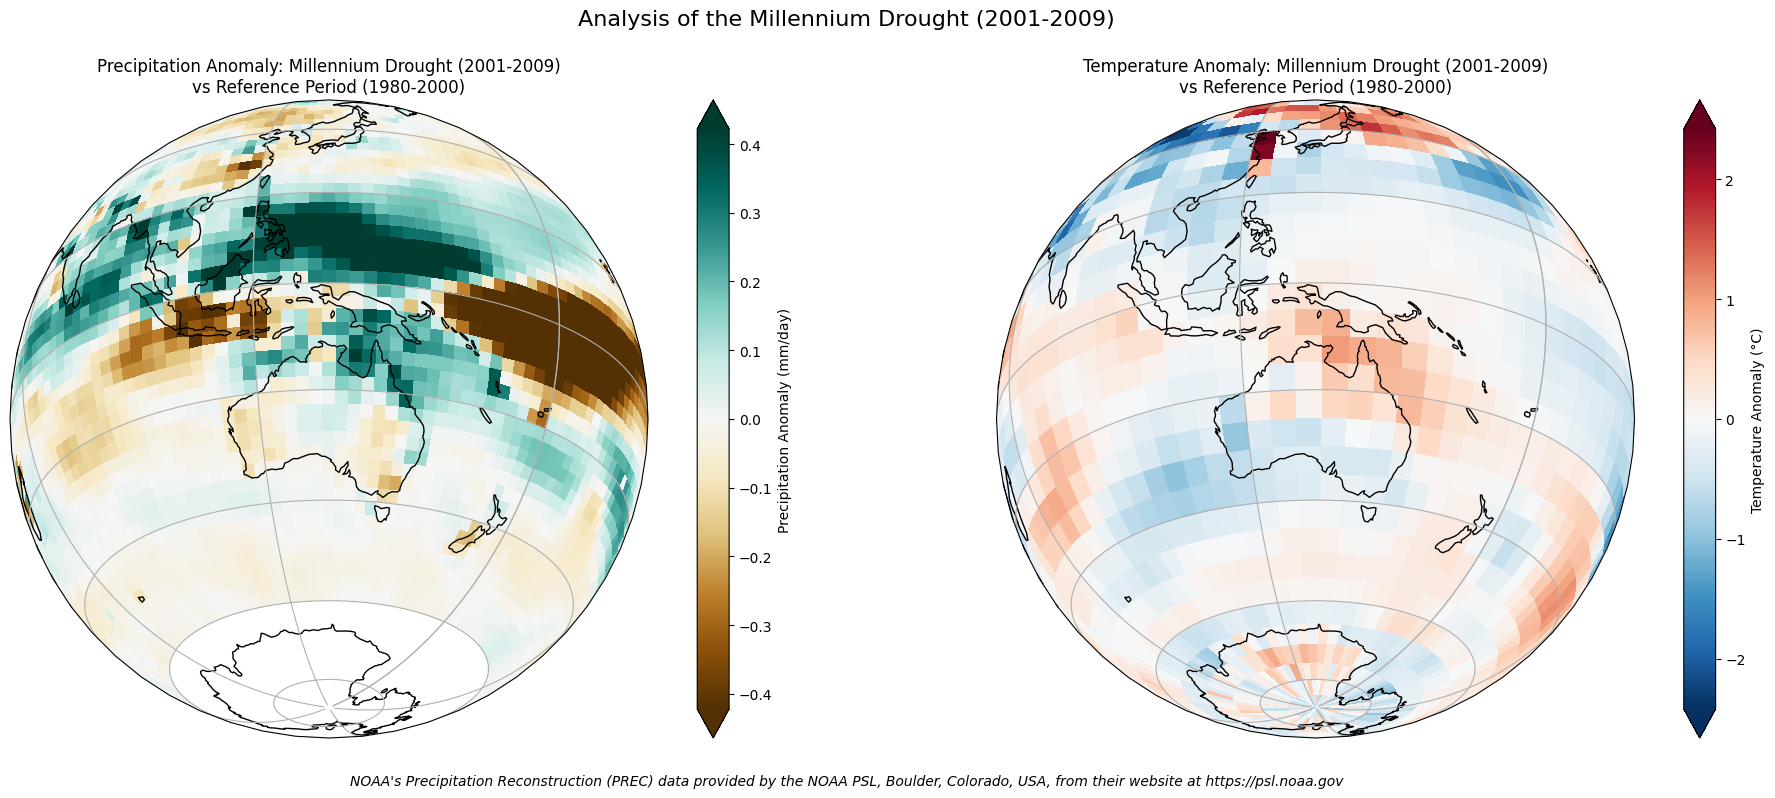

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import pandas as pd

# Define the Millennium Drought period
drought_start = '2001-01-01'
drought_end = '2009-12-31'

# 1. First, let's extract the drought period data
air_drought = air_f.sel(time=slice(drought_start, drought_end))
precip_drought = prec_f.sel(time=slice(drought_start, drought_end))

# 2. Calculate a reference period (pre-drought) for comparison
# Using 1980-2000 as reference period
reference_start = '1980-01-01'
reference_end = '2000-12-31'
air_reference = air_f.sel(time=slice(reference_start, reference_end))
precip_reference = prec_f.sel(time=slice(reference_start, reference_end))

# 3. Calculate mean values for both periods
air_drought_mean = air_drought.air.mean(dim='time')
precip_drought_mean = precip_drought.precip.mean(dim='time')
air_reference_mean = air_reference.air.mean(dim='time')
precip_reference_mean = precip_reference.precip.mean(dim='time')

# 4. Calculate the difference between drought period and reference period
air_anomaly = air_drought_mean - air_reference_mean
precip_anomaly = precip_drought_mean - precip_reference_mean

# 5. Create a visualization showing the anomalies
# Using a 1x2 layout instead of 2x2 since we're only using 2 subplots
fig = plt.figure(figsize=(20, 8))

# Temperature anomaly
ax2 = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(
    central_longitude=central_longitude, central_latitude=central_latitude))

# Precipitation anomaly
ax1 = plt.subplot(1, 2, 2, projection=ccrs.Orthographic(
    central_longitude=central_longitude, central_latitude=central_latitude))

air_plot = air_anomaly.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',  # Red-Blue colormap (reversed so blue=cold, red=warm)
    robust=True,    # Use robust color scaling
    add_colorbar=True,
    cbar_kwargs={'label': 'Temperature Anomaly (°C)'}
)
ax1.coastlines()
ax1.gridlines()
ax1.set_title(f'Temperature Anomaly: Millennium Drought (2001-2009)\nvs Reference Period (1980-2000)')

precip_plot = precip_anomaly.plot.pcolormesh(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='BrBG',    # Brown-Blue-Green (brown=dry, green=wet)
    robust=True,    # Use robust color scaling
    add_colorbar=True,
    cbar_kwargs={'label': 'Precipitation Anomaly (mm/day)'}
)
ax2.coastlines()
ax2.gridlines()
ax2.set_title(f'Precipitation Anomaly: Millennium Drought (2001-2009)\nvs Reference Period (1980-2000)')

# Add title and adjust layout
plt.suptitle('Analysis of the Millennium Drought (2001-2009)', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust the rect to leave space for title and attribution

# Add data source attribution at the bottom
fig.text(0.5, 0.01,
         'NOAA\'s Precipitation Reconstruction (PREC) data provided by the NOAA PSL, Boulder, Colorado, USA, from their website at https://psl.noaa.gov',
         ha='center', fontsize=10, style='italic')

plt.savefig('mil_temp_prec.png', format='png', dpi=600, transparent=True)
plt.show()

<ipython-input-19-2d528daca38c>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])  # Adjust the rect to leave space for title and attribution


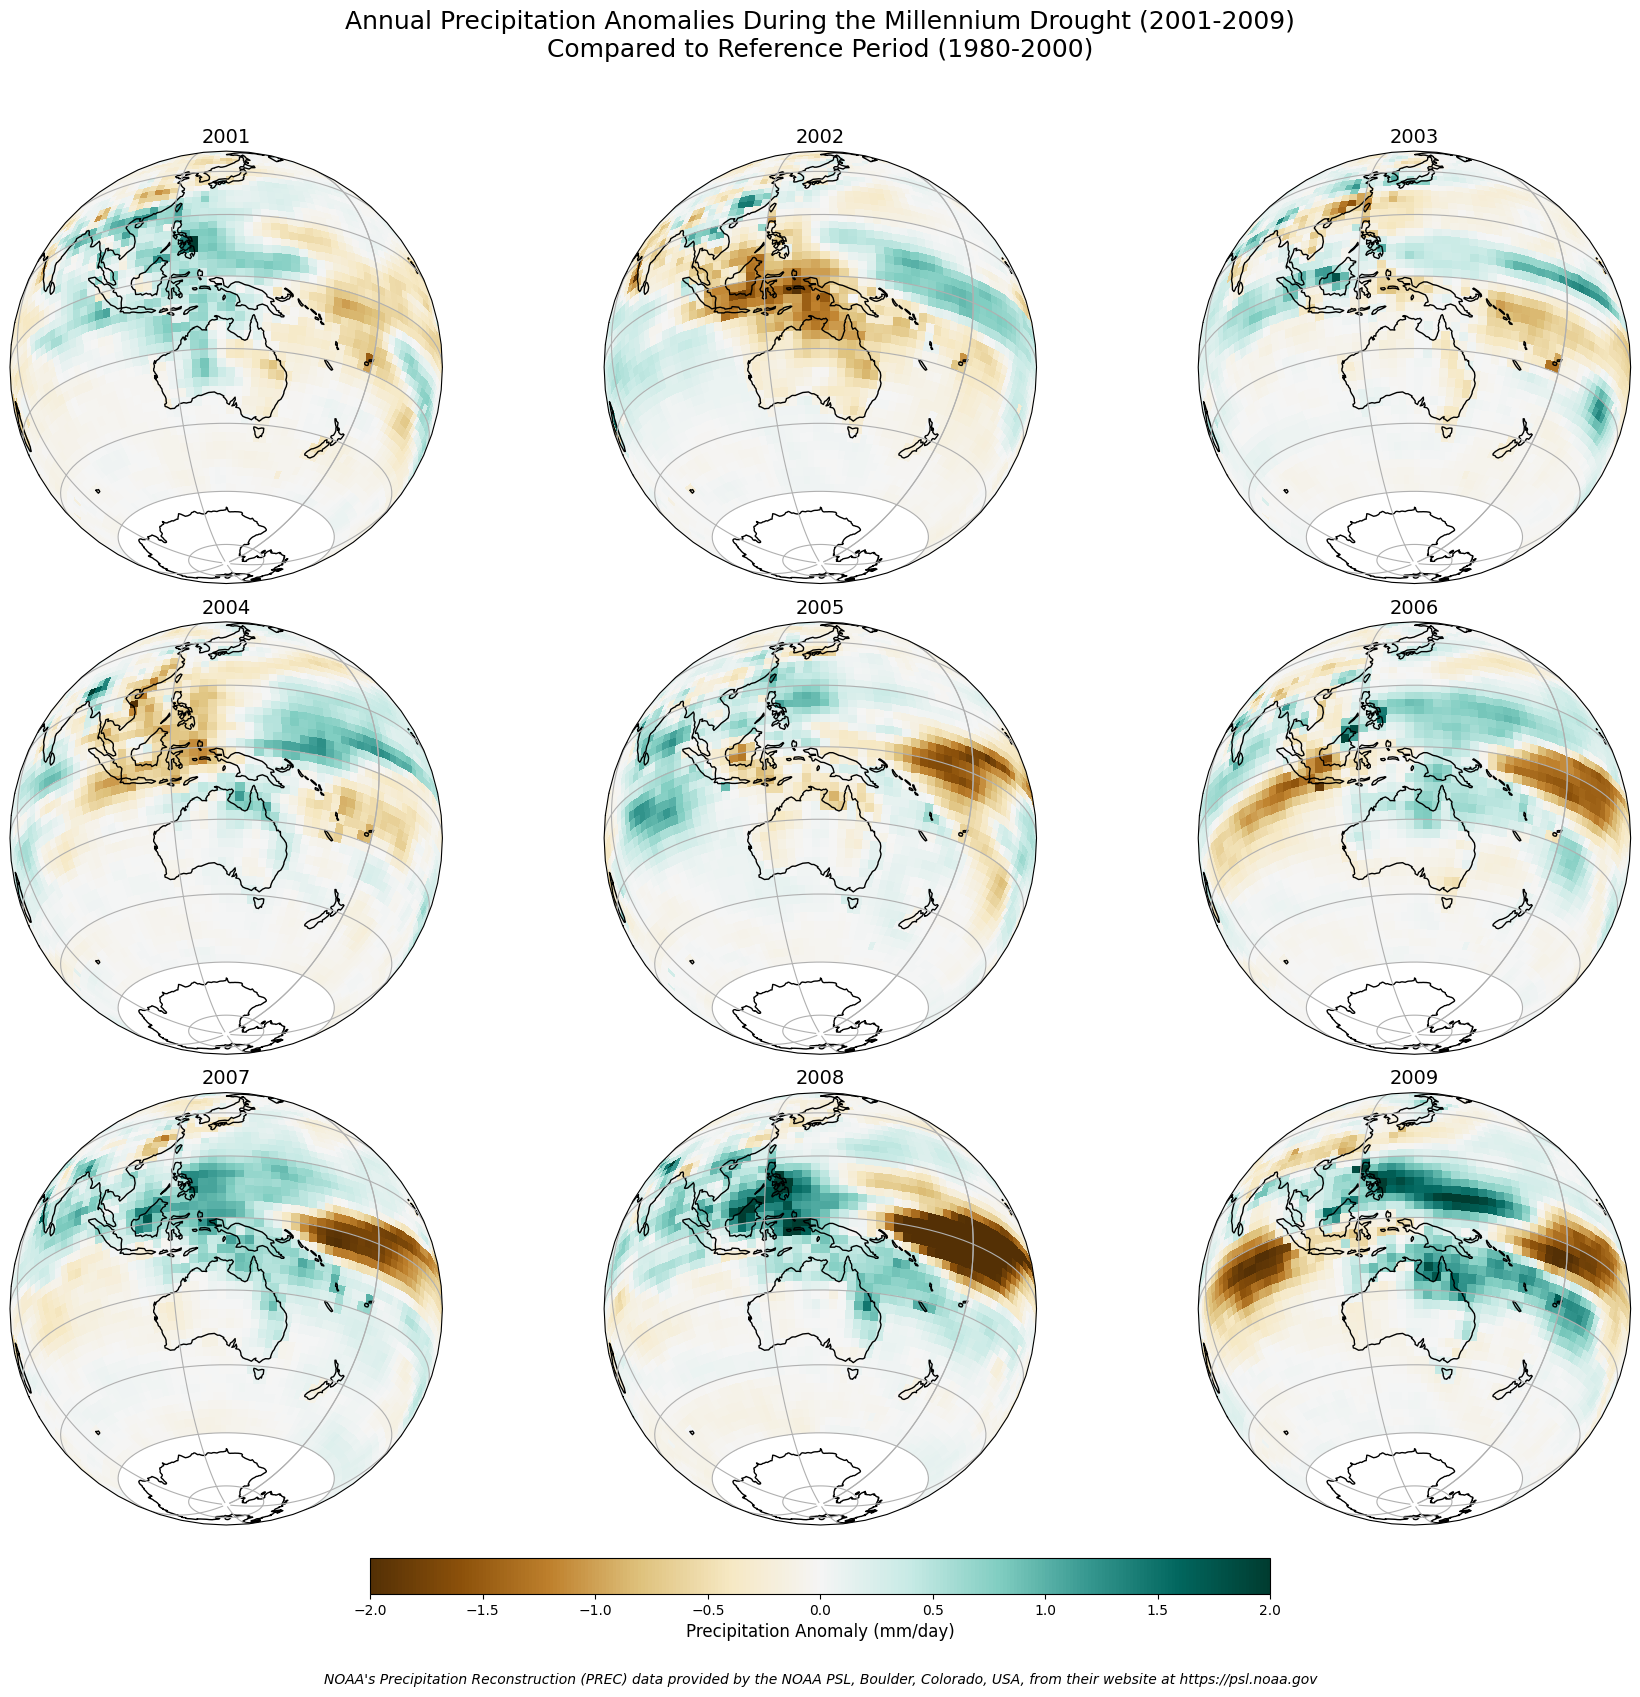

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import pandas as pd

# Define central coordinates for projection (centered on Australia)
central_longitude = 135
central_latitude = -25

# Define the reference period (pre-drought)
reference_start = '1980-01-01'
reference_end = '2000-12-31'
precip_reference = prec_f.sel(time=slice(reference_start, reference_end))
precip_reference_mean = precip_reference.precip.mean(dim='time')

# Create a 3x3 grid of globes for years 2001-2009
fig = plt.figure(figsize=(18, 18))

# Create a consistent colormap range for all plots
vmin, vmax = -2.0, 2.0  # Adjust these values based on your data range

years = range(2001, 2010)
for i, year in enumerate(years):
    # Get data for this year
    year_start = f'{year}-01-01'
    year_end = f'{year}-12-31'
    year_data = prec_f.sel(time=slice(year_start, year_end))
    year_mean = year_data.precip.mean(dim='time')

    # Calculate anomaly compared to reference period
    anomaly = year_mean - precip_reference_mean

    # Create subplot
    ax = plt.subplot(3, 3, i+1, projection=ccrs.Orthographic(
        central_longitude=central_longitude, central_latitude=central_latitude))

    # Plot the data
    precip_plot = anomaly.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='BrBG',    # Brown-Blue-Green (brown=dry, green=wet)
        vmin=vmin,      # Set consistent color scale
        vmax=vmax,
        add_colorbar=False  # We'll add one colorbar for all plots
    )

    # Add map features
    ax.coastlines()
    ax.gridlines()

    # Add year as title
    ax.set_title(f'{year}', fontsize=14)

# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.25, 0.07, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(precip_plot, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Precipitation Anomaly (mm/day)', fontsize=12)

# Add overall title
plt.suptitle('Annual Precipitation Anomalies During the Millennium Drought (2001-2009)\nCompared to Reference Period (1980-2000)',
             fontsize=18, y=0.95)

# Add data source attribution at the bottom
fig.text(0.5, 0.02,
         'NOAA\'s Precipitation Reconstruction (PREC) data provided by the NOAA PSL, Boulder, Colorado, USA, from their website at https://psl.noaa.gov',
         ha='center', fontsize=10, style='italic')

# Adjust layout
plt.tight_layout(rect=[0, 0.1, 1, 0.93])  # Adjust the rect to leave space for title and attribution

# Save high-resolution figure
plt.savefig('millennium_drought_annual_precip_anomalies.png', format='png', dpi=600, transparent=True)
plt.show()